In [ ]:
!pip install -q wandb transformers gdown

import wandb
# wandb.login()

import torch
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print(f"Pytorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Pytorch version: 2.9.0+cu126
CUDA available: True


In [ ]:
import gdown
import os
import pandas as pd

# --- 1. Download CSV Data ---
def load_csv_from_gdrive(share_url: str, **read_csv_kwargs) -> pd.DataFrame:
    file_id = share_url.split("/d/")[1].split("/")[0]
    download_url = f"https://drive.google.com/uc?id={file_id}"
    return pd.read_csv(download_url, **read_csv_kwargs)

print("Downloading CSV data...")
X_train_url = "https://drive.google.com/file/d/1geSiJTTjamysiSbJ8-W9gR1kv-x6HyEd/view?usp=drive_link"
y_train_url = "https://drive.google.com/file/d/16czWmLR5Ff0s5aYIqy1rHT7hc6Gcpfw3/view?usp=sharing"

try:
    X_train = load_csv_from_gdrive(X_train_url)
    y_train = load_csv_from_gdrive(y_train_url)

    df_dev = X_train.copy()
    df_dev['prdtypecode'] = y_train['prdtypecode']
    print(f"CSV loaded: {len(df_dev)} samples")
except Exception as e:
    print(f"CSV download failed: {e}")

# --- 2. Download and Unzip Images ---
IMAGE_FILE_ID = "15ZkS0iTQ7j3mHpxil4mABlXwP-jAN_zi"

if not os.path.exists("/content/images"):
    print("\nDownloading images...")
    !mkdir -p /content/tmp /content/images
    !gdown --id $IMAGE_FILE_ID -O /content/tmp/images.zip

    print("Unzipping images...")
    !unzip -q -o /content/tmp/images.zip -d /content/images
    print("Images unzipped")
else:
    print("\nImages already exist, skipping download")

# --- 3. Set Image Root ---
# Direct path based on your zip structure
IMG_ROOT = "/content/images/images/image_train"
print(f"Image Root: {IMG_ROOT}")

CSV loaded: 84916 samples

Images already exist, skipping download
Image Root: /content/images/images/image_train


In [ ]:
resnet_url = "https://drive.google.com/file/d/1MWtAKTHtx_1qRYLEac-DDAStZdFD47yq/view?usp=sharing"
vit_url = "https://drive.google.com/file/d/1WDaQZgNKuLvPq_J4HdWtRk1bSECPzip8/view?usp=sharing"

def download_model_from_drive(url, output_path):
    file_id = url.split("/d/")[1].split("/")[0]
    gdown_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(gdown_url, output_path, quiet=False)

print("\nDownloading ResNet weights...")
RESNET_PATH = '/content/best_model_resnet.pth'
download_model_from_drive(resnet_url, RESNET_PATH)

print("\nDownloading ViT weights...")
VIT_PATH = '/content/best_model_vit.pth'
download_model_from_drive(vit_url, VIT_PATH)

if os.path.exists(RESNET_PATH) and os.path.exists(VIT_PATH):
    print("\nModels ready!")
else:
    print("\nDownload failed")

Downloading...
From (original): https://drive.google.com/uc?id=1MWtAKTHtx_1qRYLEac-DDAStZdFD47yq
From (redirected): https://drive.google.com/uc?id=1MWtAKTHtx_1qRYLEac-DDAStZdFD47yq&confirm=t&uuid=984bccf0-e5b6-4bc6-91ad-968716570b45
To: /content/best_model_resnet.pth
100%|██████████| 295M/295M [00:02<00:00, 103MB/s] 


Downloading...
From (original): https://drive.google.com/uc?id=1WDaQZgNKuLvPq_J4HdWtRk1bSECPzip8
From (redirected): https://drive.google.com/uc?id=1WDaQZgNKuLvPq_J4HdWtRk1bSECPzip8&confirm=t&uuid=3009a08c-4fa3-4798-8506-694a1996d16e
To: /content/best_model_vit.pth
100%|██████████| 1.03G/1.03G [00:18<00:00, 57.0MB/s]



Models ready!


In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms, models
from PIL import Image

class RakutenImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, label_col="encoded_label"):
        self.image_ids = dataframe['imageid'].values
        self.product_ids = dataframe['productid'].values
        self.labels = dataframe[label_col].values
        self.image_dir = Path(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        product_id = self.product_ids[idx]
        label = self.labels[idx]

        img_name = f"image_{image_id}_product_{product_id}.jpg"
        img_path = self.image_dir / img_name

        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError):
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes, freeze_backbone=False, dropout_rate=0.3):
        super(ResNet50Classifier, self).__init__()
        self.backbone = models.resnet50(weights=None)

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.custom_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        features = self.backbone(x)
        logits = self.custom_head(features)
        return logits

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification

CONFIG = {
    "random_state": 42,
    "val_split": 0.15,
    "batch_size": 32,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

le = LabelEncoder()
le.fit(df_dev['prdtypecode'])
df_dev['encoded_label'] = le.transform(df_dev['prdtypecode'])
num_classes = len(le.classes_)
print(f"Num classes: {num_classes}")

train_indices, val_indices = train_test_split(
    df_dev.index,
    test_size=CONFIG['val_split'],
    random_state=CONFIG['random_state'],
    stratify=df_dev['encoded_label']
)

df_train = df_dev.loc[train_indices].reset_index(drop=True)
df_val = df_dev.loc[val_indices].reset_index(drop=True)

resnet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("Loading ResNet...")
resnet_model = ResNet50Classifier(num_classes=num_classes)
state_dict = torch.load(RESNET_PATH, map_location=CONFIG['device'])
if 'model_state_dict' in state_dict:
    state_dict = state_dict['model_state_dict']
resnet_model.load_state_dict(state_dict)
resnet_model.to(CONFIG['device'])
resnet_model.eval()
print("ResNet loaded")

print("Loading ViT...")
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
state_dict_vit = torch.load(VIT_PATH, map_location=CONFIG['device'])
if 'model_state_dict' in state_dict_vit:
    state_dict_vit = state_dict_vit['model_state_dict']
vit_model.load_state_dict(state_dict_vit)
vit_model.to(CONFIG['device'])
vit_model.eval()
print("ViT loaded")

Num classes: 27
Loading ResNet...
ResNet loaded
Loading ViT...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([27]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([27, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT loaded


In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score

val_ds_resnet = RakutenImageDataset(df_val, IMG_ROOT, transform=resnet_transform)
val_loader_resnet = DataLoader(val_ds_resnet, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

val_ds_vit = RakutenImageDataset(df_val, IMG_ROOT, transform=vit_transform)
val_loader_vit = DataLoader(val_ds_vit, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

print("Running ResNet Inference...")
resnet_probs = []
y_true = []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader_resnet):
        imgs = imgs.to(CONFIG['device'])
        outputs = resnet_model(imgs)
        probs = F.softmax(outputs, dim=1)
        resnet_probs.append(probs.cpu().numpy())
        y_true.extend(labels.numpy())
resnet_probs = np.concatenate(resnet_probs)
y_true = np.array(y_true)

print("Running ViT Inference...")
vit_probs = []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader_vit):
        imgs = imgs.to(CONFIG['device'])
        outputs = vit_model(pixel_values=imgs)
        probs = F.softmax(outputs.logits, dim=1)
        vit_probs.append(probs.cpu().numpy())
vit_probs = np.concatenate(vit_probs)

acc_res = accuracy_score(y_true, np.argmax(resnet_probs, axis=1))
f1_res = f1_score(y_true, np.argmax(resnet_probs, axis=1), average='weighted')
acc_vit = accuracy_score(y_true, np.argmax(vit_probs, axis=1))
f1_vit = f1_score(y_true, np.argmax(vit_probs, axis=1), average='weighted')

print(f"\nResNet Baseline: Acc={acc_res:.4f}, F1={f1_res:.4f}")
print(f"ViT Baseline:    Acc={acc_vit:.4f}, F1={f1_vit:.4f}")

Running ResNet Inference...


  0%|          | 0/399 [00:00<?, ?it/s]

Running ViT Inference...


  0%|          | 0/399 [00:00<?, ?it/s]


ResNet Baseline: Acc=0.6846, F1=0.6808
ViT Baseline:    Acc=0.7006, F1=0.6983


Searching for best alpha...

Best Alpha: 0.50
Best Fusion F1: 0.7177
Best Fusion Acc: 0.7214


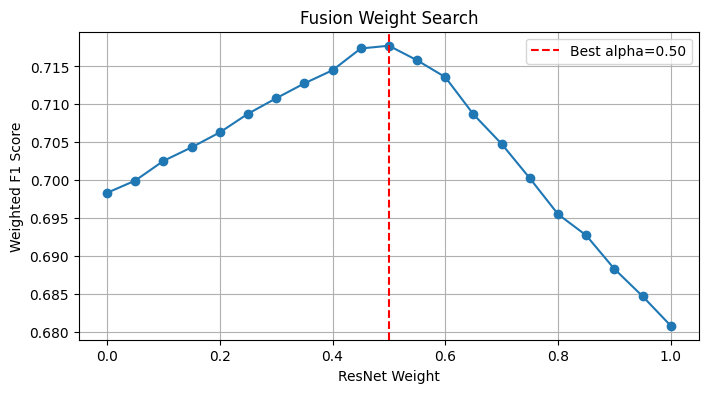

In [ ]:
import matplotlib.pyplot as plt

print("Searching for best alpha...")
best_alpha = 0.0
best_f1 = 0.0
best_acc = 0.0
results = []

for alpha in np.arange(0.0, 1.05, 0.05):
    final_probs = alpha * resnet_probs + (1 - alpha) * vit_probs
    preds = np.argmax(final_probs, axis=1)

    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds, average='weighted')

    results.append({"alpha": alpha, "acc": acc, "f1": f1})
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        best_alpha = alpha

print(f"\nBest Alpha: {best_alpha:.2f}")
print(f"Best Fusion F1: {best_f1:.4f}")
print(f"Best Fusion Acc: {best_acc:.4f}")

results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 4))
plt.plot(results_df['alpha'], results_df['f1'], marker='o')
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best alpha={best_alpha:.2f}')
plt.title('Fusion Weight Search')
plt.xlabel('ResNet Weight')
plt.ylabel('Weighted F1 Score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

class DualDataset(Dataset):
    def __init__(self, df, img_dir, trans_res, trans_vit, label_col='encoded_label'):
        self.image_ids = df['imageid'].values
        self.product_ids = df['productid'].values
        self.labels = df[label_col].values
        self.img_dir = Path(img_dir)
        self.trans_res = trans_res
        self.trans_vit = trans_vit

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        product_id = self.product_ids[idx]
        label = self.labels[idx]
        img_name = f"image_{image_id}_product_{product_id}.jpg"
        img_path = self.img_dir / img_name

        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new('RGB', (224, 224), (0,0,0))

        return self.trans_res(img), self.trans_vit(img), torch.tensor(label, dtype=torch.long)

class FusionNet(nn.Module):
    def __init__(self, resnet, vit, num_classes=27):
        super().__init__()
        self.resnet_backbone = resnet.backbone
        self.vit_backbone = vit.vit

        for p in self.resnet_backbone.parameters(): p.requires_grad = False
        for p in self.vit_backbone.parameters(): p.requires_grad = False

        self.head = nn.Sequential(
            nn.Linear(2816, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x_res, x_vit):
        with torch.no_grad():
            feat_res = self.resnet_backbone(x_res)
            if len(feat_res.shape) > 2:
                feat_res = torch.flatten(feat_res, 1)

            out_vit = self.vit_backbone(pixel_values=x_vit)
            feat_vit = out_vit.last_hidden_state[:, 0]

        combined = torch.cat([feat_res, feat_vit], dim=1)
        return self.head(combined)

train_ds_dual = DualDataset(df_train, IMG_ROOT, resnet_transform, vit_transform)
train_loader_dual = DataLoader(train_ds_dual, batch_size=32, shuffle=True, num_workers=2)

val_ds_dual = DualDataset(df_val, IMG_ROOT, resnet_transform, vit_transform)
val_loader_dual = DataLoader(val_ds_dual, batch_size=32, shuffle=False, num_workers=2)

fusion_model = FusionNet(resnet_model, vit_model).to(CONFIG['device'])
optimizer = AdamW(fusion_model.head.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

print("Start training Fusion Head...")
epochs = 10
best_val_f1 = 0.0

for epoch in range(epochs):
    fusion_model.train()
    train_loss = 0

    for x_res, x_vit, y in tqdm(train_loader_dual, desc=f"Epoch {epoch+1}"):
        x_res, x_vit, y = x_res.to(CONFIG['device']), x_vit.to(CONFIG['device']), y.to(CONFIG['device'])

        optimizer.zero_grad()
        outputs = fusion_model(x_res, x_vit)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    fusion_model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for x_res, x_vit, y in val_loader_dual:
            x_res, x_vit, y = x_res.to(CONFIG['device']), x_vit.to(CONFIG['device']), y.to(CONFIG['device'])
            outputs = fusion_model(x_res, x_vit)
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_targets.extend(y.cpu().numpy())

    val_f1 = f1_score(val_targets, val_preds, average='weighted')
    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader_dual):.4f}, Val F1={val_f1:.4f}")

    scheduler.step(val_f1)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(fusion_model.state_dict(), "best_fusion_head.pth")

Start training Fusion Head...


Epoch 1:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.4687, Val F1=0.7044


Epoch 2:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.3867, Val F1=0.7083


Epoch 3:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.3504, Val F1=0.7143


Epoch 4:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.3172, Val F1=0.7056


Epoch 5:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.2934, Val F1=0.7137


Epoch 6:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.2649, Val F1=0.7117


Epoch 7:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.1875, Val F1=0.7144


Epoch 8:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.1542, Val F1=0.7134


Epoch 9:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.1393, Val F1=0.7130


Epoch 10:   0%|          | 0/2256 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.1100, Val F1=0.7173
